In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        DoubleTabularQLearner(
            lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.98
        )
        for i in range(population)
    ]

    G = nx.connected_caveman_graph(communities, size)

    # G = nx.Graph()
    # G.add_weighted_edges_from([
    #     (0, i, 1) for i in range(1, population)
    # ])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [5]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/30000 [00:00<?, ?it/s]

BEST AGENT (6): 181428 (0.9035161481204647, DCCCCDCCCCCCCDCC)
WORST AGENT (9): 145483 (0.5905642376885335, DCCCCCCCDCCCCCCD)


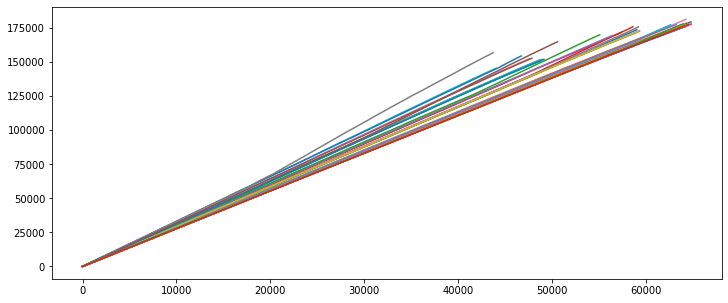

In [7]:
POPULATION = (1, 64)
ROUNDS = 30_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

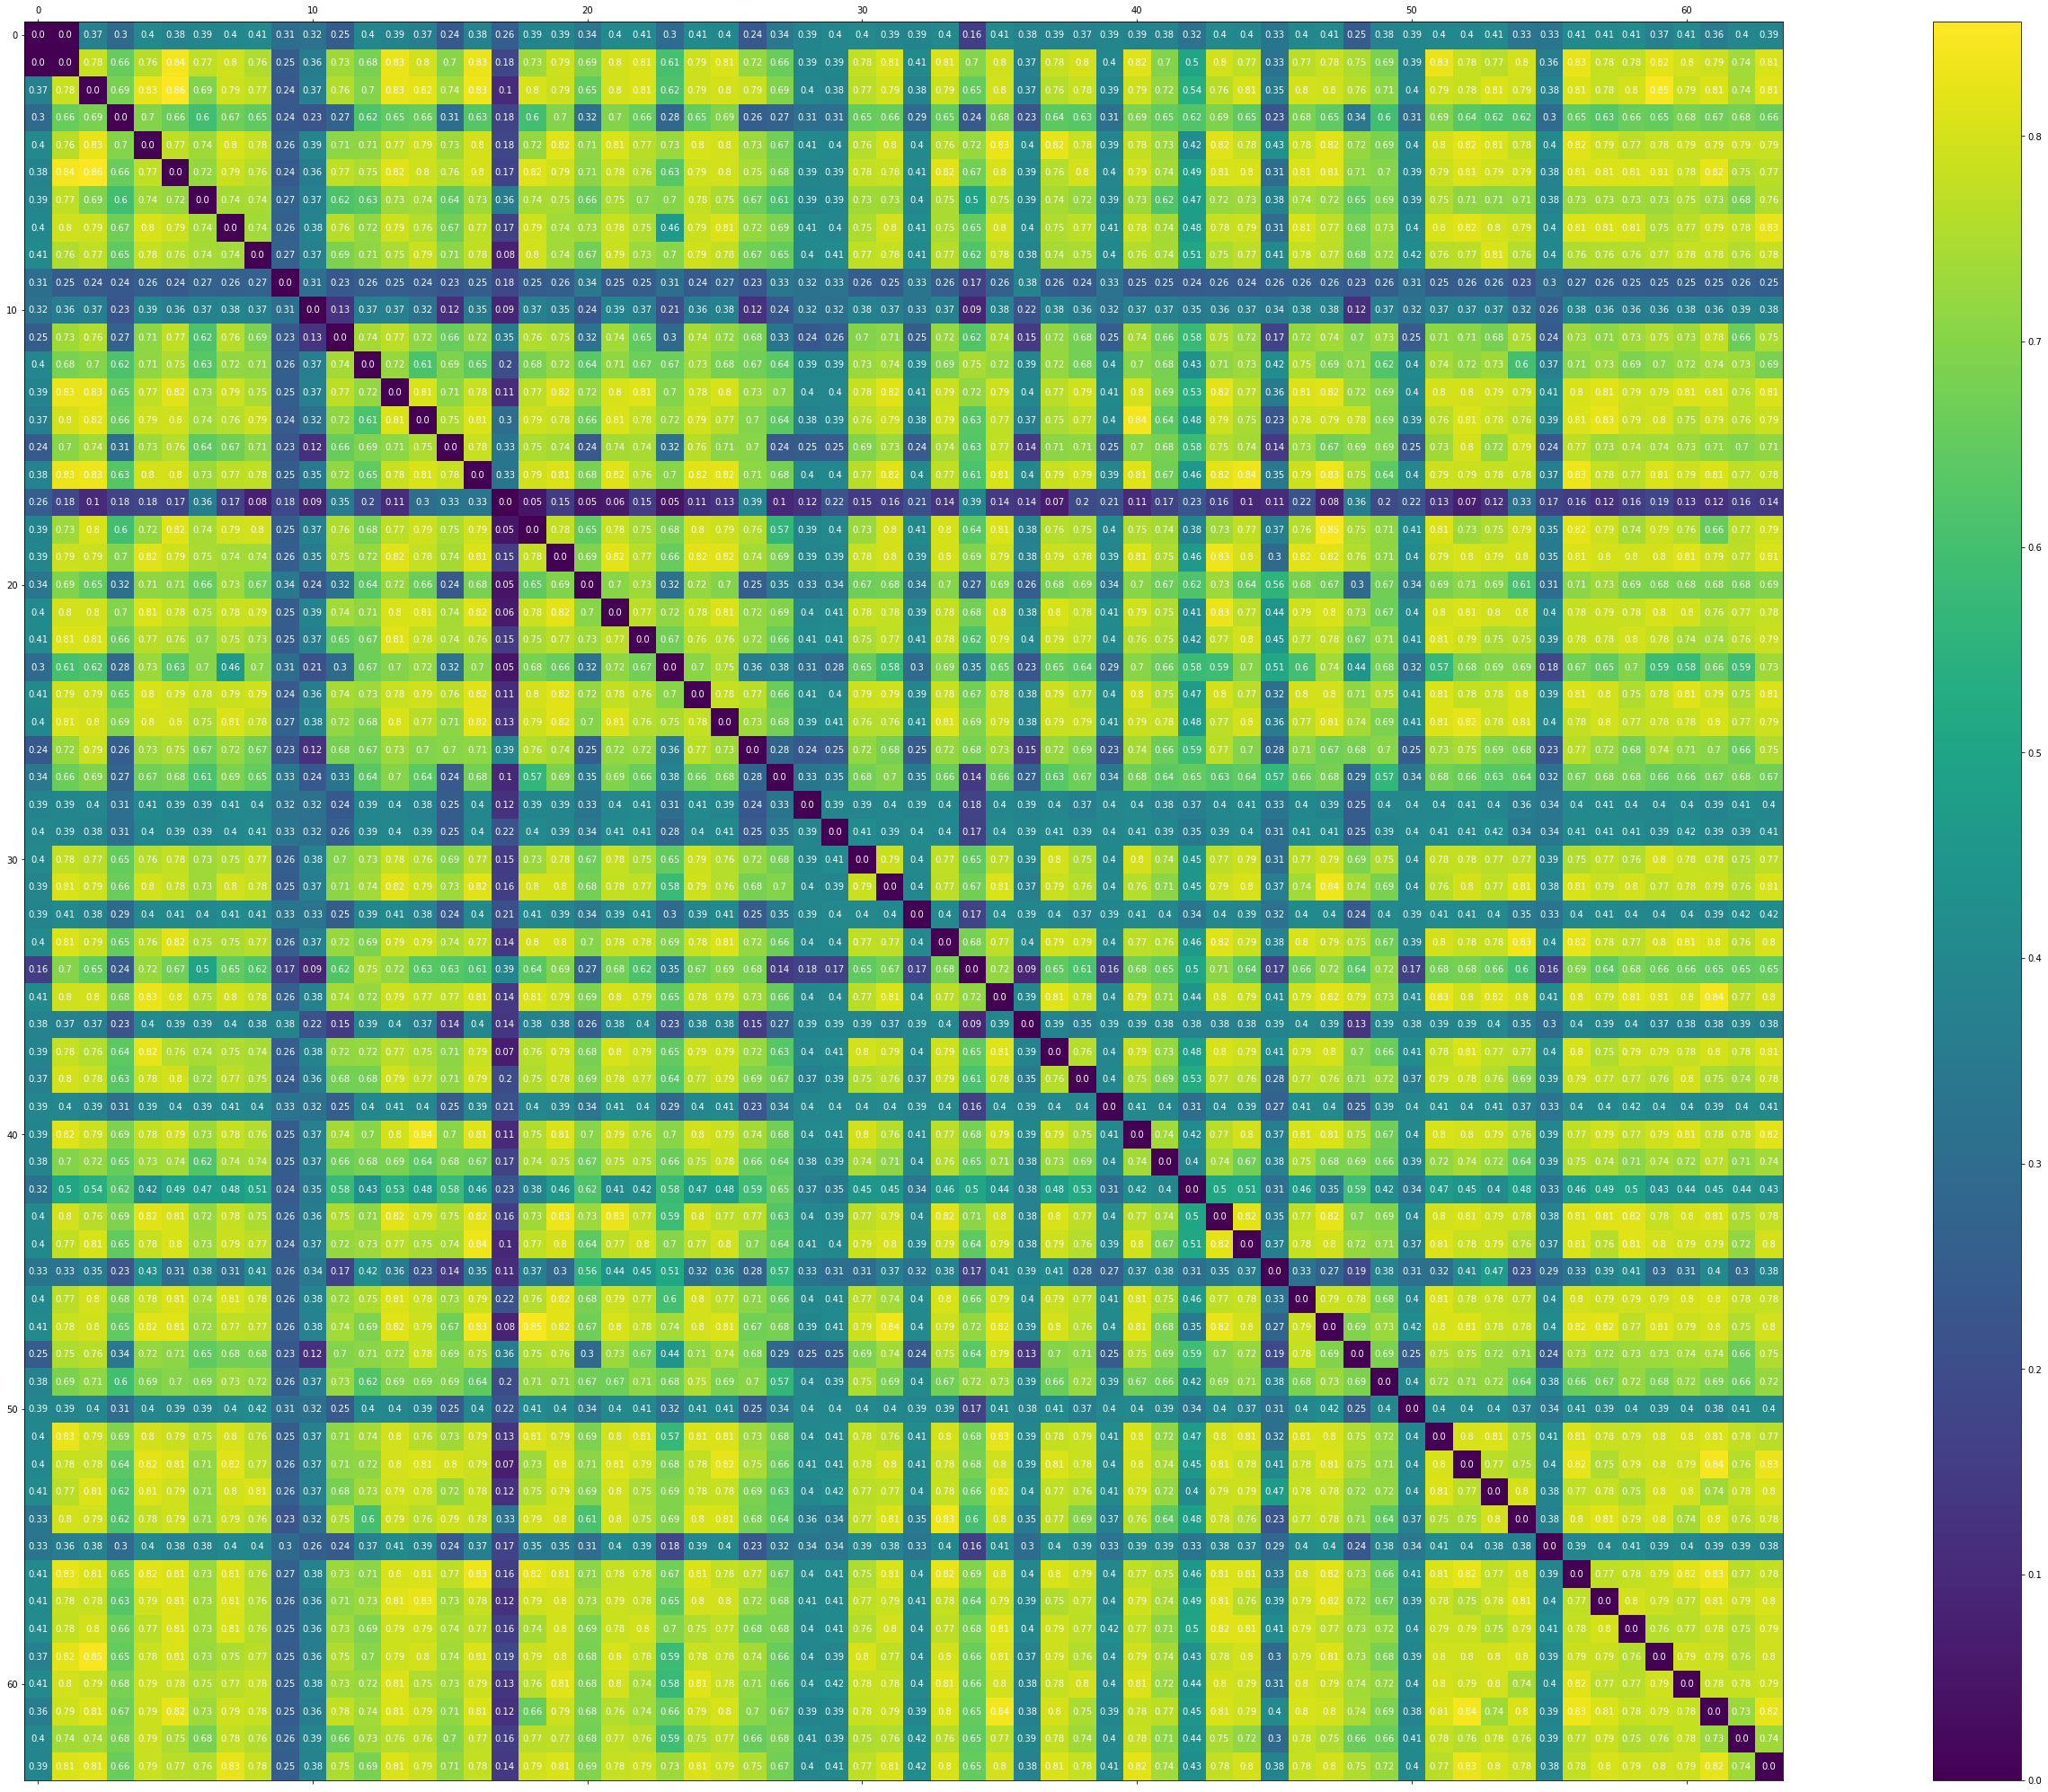

In [8]:
plot_matrix(sim.produce_weight_matrix(), digits=2, figsize=(60, 36))

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [10]:
sim.calculate_weights()

[[0.37397215167138326,
  0.29533602853745544,
  0.4012793447723052,
  0.38226130598166363,
  0.3889284764886578,
  0.3994746248831064,
  0.4084086295393194,
  0.30839803777593777,
  0.323236965029668,
  0.2534601664684899,
  0.39514917918724723,
  0.3865521097234021,
  0.3659503124523701,
  0.24368446567078428,
  0.3810394756896814,
  0.25606038612280446,
  0.38755928261381145,
  0.3916771880756961,
  0.3354967110811266,
  0.40467618123295773,
  0.4068779104373096,
  0.3006749664570422,
  0.4055118054038931,
  0.3998917437936449,
  0.23723617717003567,
  0.3382965431070387,
  0.38674785277592133,
  0.39731811953909385,
  0.40182150155055235,
  0.3892364648537463,
  0.38570637119113577,
  0.40344169577228045,
  0.16000000000000003,
  0.40642644987076737,
  0.3824277689075586,
  0.38508647221484477,
  0.37419722471768296,
  0.3929605702829138,
  0.3862967785493827,
  0.38167002719832166,
  0.3241179677890912,
  0.40377133384197833,
  0.3993096765233201,
  0.331543189791761,
  0.398735921

In [11]:
sim.action_histories[0][2]

[<Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERA

In [12]:
cumulative_rewards[0][0]

6

In [13]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[255.45545207 258.23005419]
  [257.38111494 246.98045503]
  [258.09873382 218.87444296]
  [255.31071902  74.52370554]]

 [[257.44882416 249.45883457]
  [121.81674964 251.19225977]
  [257.42988418 120.04618508]
  [233.76001339  13.12855123]]

 [[258.1436857  255.07838362]
  [254.89107427 141.16724013]
  [252.641683    48.0427717 ]
  [ 96.59683011   0.        ]]

 [[258.57300303 190.69602449]
  [ 22.72274955 226.01164783]
  [167.0866958   19.06971217]
  [ 33.28637399   0.        ]]]


In [28]:
agents[cumulative_rewards[4][0]].play_move(
    [Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE]
)

<Action.COOPERATE: 0>

In [14]:
agents[1]._q_table

array([[[267.44083956, 265.15656838],
        [267.38163097, 252.58652884],
        [268.13991436, 209.06493633],
        [241.12752456,  11.12761397]],

       [[267.10248452, 265.0268098 ],
        [265.83404464, 113.59846471],
        [266.44708639,  35.08646852],
        [147.75083961,   0.3       ]],

       [[268.34918746, 251.40201255],
        [267.09068991,  99.33772694],
        [255.20691228,  25.62113592],
        [ 81.50615417,   0.81105926]],

       [[103.19194002, 257.66851925],
        [171.4937276 ,   0.        ],
        [  6.61620577,  54.7580492 ],
        [  0.        ,   3.44830878]]])

In [15]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [16]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [17]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

1.0                      DCCCCDCCCCCCCDCC
4.0                      DCCCDCCCCCCCCCCC
7.0                      CCCCCCCDCCCCCDCC
10.0                     CCCCCDCCCCCCCCCC
13.0                     DCCDDCCDCCCDCCCD
14.0                     CCCDCDDCCCCDCCCD
15.5                     CCCCDCCCCCCCCCCC
19.0                     CCCCCCCCCCCCCCCD
21.0                     CCCCCCCCCCCCDCCC
23.5                     DCDCCCCCCCCCCCCC
25.0                     CCCCCCDCCCCCCCCC
26.636363636363637       CCCCCCCCCCCCCCCC
27.0                     CCCCCCCCCCCCDCCD
27.444444444444443       DCCCCCCCCCCCCCCC
28.0                     CCCDCCCDCCCCCCCC
34.0                     CCCDCCCCCCCCCCCC
34.0                     CCCDCDCCCCCCCCCC
35.0                     DCCDDCCCDCCCCDCC
36.0                     DCCCDCCCDCCCCCCC
38.0                     CCCCCCCCCCCCDCDD
39.0                     CCCDCCCCCCCCCDCD
41.0                     CCCCCCCCCDCCCCCC
42.0                     DCCCDCDCCCCCCCCC
44.0                     CCDCCCCCC

In [18]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

181428.0                 DCCCCDCCCCCCCDCC
178869.33333333334       DCCCDCCCCCCCCCCC
178150.0                 CCCCCCCDCCCCCDCC
177936.0                 CCCCCDCCCCCCCCCC
177623.5                 CCCCDCCCCCCCCCCC
177606.0                 DCCDDCCDCCCDCCCD
177474.0                 CCCDCDDCCCCDCCCD
177056.0                 CCCCCCCCCCCCCCCD
177028.0                 CCCCCCCCCCCCDCCC
176840.0                 DCDCCCCCCCCCCCCC
176800.0                 CCCCCCDCCCCCCCCC
176590.0                 CCCCCCCCCCCCDCCD
176520.63636363635       CCCCCCCCCCCCCCCC
176478.0                 CCCDCCCDCCCCCCCC
176159.0                 CCCDCDCCCCCCCCCC
176035.0                 DCCDDCCCDCCCCDCC
175954.0                 CCCDCCCCCCCCCCCC
175934.0                 DCCCDCCCDCCCCCCC
175565.0                 CCCCCCCCCCCCDCDD
175563.0                 CCCDCCCCCCCCCDCD
175221.0                 CCCCCCCCCDCCCCCC
175024.0                 DCCCDCDCCCCCCCCC
174419.0                 CCDCCCCCCCCDCCCC
173785.0                 DCCCDCCDC

In [19]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'DCCCCDCCCCCCCDCC'

In [20]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[255.45545207 258.23005419]
  [257.38111494 246.98045503]
  [258.09873382 218.87444296]
  [255.31071902  74.52370554]]

 [[257.44882416 249.45883457]
  [121.81674964 251.19225977]
  [257.42988418 120.04618508]
  [233.76001339  13.12855123]]

 [[258.1436857  255.07838362]
  [254.89107427 141.16724013]
  [252.641683    48.0427717 ]
  [ 96.59683011   0.        ]]

 [[258.57300303 190.69602449]
  [ 22.72274955 226.01164783]
  [167.0866958   19.06971217]
  [ 33.28637399   0.        ]]]


In [21]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => D
('(C, C)', '(C, D)') => C
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => D
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => C
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => D
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
